<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <font style="color:#00797C;padding-bottom:-100px"><center><b><font size="+3">The Angle Specification for GSLIB Software</font></b></center></p>
    <font style="color:#00797C;padding-bottom:50px"><center><b><font size="+2">A Companion Notebook to Geostatistics Lessons</font></b></center></p>    
</div>

<p class="author" style="padding: 0;"><center><b>Ben Harding and Matthew Deutsch</b></center></p>
<p class="date" style="padding: 0;"><center><b>March 7, 2025</b></center></p>

---

# Outline

This notebook complements the mathematical concepts discussed in [The Angle Specification for GSLIB Software](https://geostatisticslessons.com/lessons/anglespecification). Understanding the orientation of anisotropy in three-dimensional space is essential for geostatistical modeling. It influences key processes such as calculating experimental variograms along specific directions, aligning search ellipsoids for kriging and simulation with geologic continuity, and re-orienting coordinate systems for modeling efficiency. This notebook illustrates how to construct and apply GSLIB convention rotation matrices to align an ellipsoid with its principal continuity directions.

1. **Define Rotation Matrices**
    - Define functions to return the three elemental rotation matrices.
    - Define a function to return a full GSLIB Z-X-Y rotation matrix.
2. **Rotate 2D Ellipse**
    - Initialize an anisotropic two-dimensional ellipse.
    - Demonstrate rotating the ellipse about the Z-axis (angle 1).
2. **Rotate 3D Ellipsoid**
    - Initialize a rotated, anisotropic three-dimensional target ellipsoid from a fitted variogram model.
    - Initialize an unrotated copy of the target (source ellipsoid).
    - Demonstrate the three elemental rotations (angles 1, 2 and 3) to align the source ellipsoid with the target, visualizing the intermediate orientations.
    - Demonstrate applying the full rotation matrix to the source and reversing the rotations with $R^{T}$.
2. **Rotation Conventions**
    - Demonstrate converting angles from another rotation convention to GSLIB angles.


The presented workflow may be extended to represent other deposits. Inline annotations with each step will note practical adjustments that may be necessary for this extension.

---

Import required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import rmsp

Import numpy functions to facilitate trigonometry:

In [2]:
from numpy import sin, cos, radians

Activate rmsp and set global parameters:

In [3]:
rmsp.activate()
log_progress = False  # Set to true for progressbars on intensive tasks
rmsp.GlobalParams["core.log_progress"] = log_progress
rmsp.GlobalParams["core.enable_beta"] = True

License cleq45ynq00htgomxajqjmhjb checked out by ryan@resmodsol.com to clhpc9e08024vlb2mj25gvz0b expires in 60 minutes. RMSP is up to date!


Define some plotting parameters and functions. **This section can likely be ignored as it does not relate to the core focus of the notebook.**

In [4]:
grid_plot_params = {"c": "0.8", "block_shrink": 1.0}

arrow_pars = {
    "2d": {"radius": 0.125, "head_width_scale": 2.75},
    "3d": {"radius": 1.5, "head_width_scale": 1.75},
}

arrow_kws = {
    "2d": [
        {"face_c": "green", "alpha": 1.0, "face_label": "Major"},
        {"face_c": "red", "alpha": 1.0, "face_label": "Minor"},
        {"face_c": "blue", "alpha": 1.0, "face_label": "Vertical"},
    ],
    "3d": [
        {"color": "green", "alpha": 1.0, "label": "Major"},
        {"color": "red", "alpha": 1.0, "label": "Minor"},
        {"color": "blue", "alpha": 1.0, "label": "Vertical"},
    ],
}

camera_params = {
    "plan": [0.00, 0.00, 727.87, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00],
    "oblique": [549.27, -413.79, 69.94, 0.00, 0.00, 0.00, -0.09, 0.05, 0.99],
}


def annotate_2d_ellipse(ax, principals, arrow_kws):
    """Annotate the principal axes of a rotated ellipse in 2D.

    Args:
        ax (mpl.Axes): axes handle to return the plot
        principals (list): list of principal arrows to plot
        arrow_kws (list(dict)): a list of `rmsp.Solid.arrow` plotting kwds
            in the order of major, minor, vertical
    """
    for principal, kws in zip(principals, arrow_kws):
        principal.sectionplot_draw(ax=ax, **kws)
    return ax


def annotate_3d_ellipsoid(vw, principals, arrow_kws):
    """Annotate the principal axes of a rotated ellipsoid in 3D.

    Args:
        vw (rmsp.Viewer): axes handle to return the plot
        principals (list): list of principal arrows to plot
        arrow_kws (list(dict)): a list of `rmsp.Solid.arrow` plotting kwds
            in the order of major, minor, vertical
    """
    for principal, kws in zip(principals, arrow_kws):
        principal.view3d(viewer=vw, **kws)
    return vw


def view_ellipsoids(target_ellipsoid, ellipsoid,
                    principals, label):
    """Return view of target ellipsoid with rotated ellipsoid

    The principal arrows associated with the rotated ellipsoid are
    also plotted.

    Args:
        target_ellipsoid (rmsp.Solid): target ellipsoid
        ellipsoid (rmsp.Solid): progressively rotated ellipsoid
        principals (list): list of principal directions corresponding
            with ellipsoid
        label (str): label applied to ellipsoid
    """
    # Generate scene
    vw = target_ellipsoid.view3d(color="C0", alpha=0.2, label="Target")
    ellipsoid.view3d(viewer=vw, color="C3", alpha=0.2, label=label)
    vw = annotate_3d_ellipsoid(vw, principals, arrow_kws["3d"])
    # Plot and annotate multiple static views
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))
    for (name, angle), ax in zip(camera_params.items(), axes):
        vw.set_camera(angle)
        vw.show_static(axis_kws={'font_size': 15}, ax=ax,
                       title=name.capitalize() + " View")
    fig.tight_layout(w_pad=-10)
    for ax in axes:
        ax.legend()
    return vw  # return interactive viewer

Define additional functions to (1) rotate the ellipsoid object and (2) define and plot the principal axes of the ellipsoid. **Again, understanding of these functions are not essential to the notebook focus.**

In [5]:
def rotate_ellipsoid(ellipsoid, rotation_matrix):
    """Rotate `ellipsoid` by `rotation_matrix`.

    Args:
        ellipsoid (rmsp.Solid.ellipsoid): ellipsoid object to be rotated
        rotation_matrix (np.ndarray (3x3)): matrix defining rotations in Z-X-Y convention
    """
    rot_ellipsoid = deepcopy(ellipsoid)
    xyz = np.vstack(ellipsoid.coords())
    uvw = np.matmul(rotation_matrix.T, xyz)
    rot_ellipsoid.x = uvw[0, :]
    rot_ellipsoid.y = uvw[1, :]
    rot_ellipsoid.z = uvw[2, :]
    return rot_ellipsoid


def get_principal_axes(ranges, rotation_matrix, origin, arrow_pars,
                       major=True, minor=True, vert=True):
    """Helper function to generate arrows of the principal axes of the rotated ellipsoid

    Args:
        rotation_matrix (np.ndarray (3x3)): matrix defining rotations in Z-X-Y convention
        origin (three tuple): origin of principal axes
        defined by `rotation_matrix`
        major (bool): get the major axis?
        minor (bool): get the minor axis?
        vert (bool): get the vertical axis?
    """
    amaj, amin, avrt = ranges
    xt = [origin[0], amin, origin[2]]
    yt = [amaj, origin[1], origin[2]]
    zt = [origin[0], origin[1], avrt]
    xyz = np.array([xt, yt, zt])
    uvw = np.matmul(rotation_matrix.T, xyz)
    principals = []
    if major:
        principals.append(
            rmsp.Solid.arrow(origin, (uvw[0, 0], uvw[1, 0], uvw[2, 0]), **arrow_pars))
    if minor:
        principals.append(
            rmsp.Solid.arrow(origin, (uvw[0, 1], uvw[1, 1], uvw[2, 1]), **arrow_pars))
    if vert:
        principals.append(
            rmsp.Solid.arrow(origin, (uvw[0, 2], uvw[1, 2], uvw[2, 2]), **arrow_pars))
    return principals

---
# Rotation Matrices

Define a set of functions to return each elemental rotation matrix (about the Z, X, and Y axes), as well as a function to return the full GSLIB style rotation matrix defined by angles 1, 2, and 3.

In [6]:
def about_z(ang1):
    """Return the matrix for rotation about the Z-axis

    Args:
        ang1 (float): angle 1 rotation (azimuth) in radians
    """
    return np.array([[cos(ang1), -sin(ang1), 0], [sin(ang1), cos(ang1), 0], [0, 0, 1]])


def about_x(ang2):
    """Return the matrix for rotation about the X-axis

    Args:
        ang2 (float): angle 2 rotation (inclination) in radians
    """
    return np.array([[1, 0, 0], [0, cos(ang2), sin(ang2)], [0, -sin(ang2), cos(ang2)]])


def about_y(ang3):
    """Return the matrix for rotation about the Y-axis

    Args:
        ang3 (float): angle 3 rotation (tilt) in radians
    """
    return np.array([[cos(ang3), 0, -sin(ang3)], [0, 1, 0], [sin(ang3), 0, cos(ang3)]])


def gslib_rotation_matrix(ang1, ang2, ang3):
    """Return the full GSLIB Z-X-Y rotation matrix

    Args:
        ang1 (float): angle 1 rotation (azimuth) in radians
        ang2 (float): angle 2 rotation (inclination) in radians
        ang3 (float): angle 3 rotation (tilt) in radians
    """
    rotmat = np.zeros((3, 3))
    rotmat[0, :] = (
        cos(ang1) * cos(ang3) + sin(ang1) * sin(ang2) * sin(ang3),
        -sin(ang1) * cos(ang3) + cos(ang1) * sin(ang2) * sin(ang3),
        -cos(ang2) * sin(ang3),
    )
    rotmat[1, :] = sin(ang1) * cos(ang2), cos(ang1) * cos(ang2), sin(ang2)
    rotmat[2, :] = (
        cos(ang1) * sin(ang3) - sin(ang1) * sin(ang2) * cos(ang3),
        -sin(ang1) * sin(ang3) - cos(ang1) * sin(ang2) * cos(ang3),
        cos(ang2) * cos(ang3),
    )
    return rotmat

Test that the multiplication of the individual rotation matrices yields the final rotation matrix. Note the matrix multiplication is non-commutative and thus the order matters.

In [7]:
ang1, ang2, ang3 = radians(113), radians(34), radians(-17)
rm0 = np.matmul(about_y(ang3), np.matmul(about_x(ang2), about_z(ang1)))
rm1 = gslib_rotation_matrix(ang1, ang2, ang3)
np.allclose(rm0, rm1)

True

---
# 2D Example

This example demonstrates the simple rotation of an ellipse in 2D using a range of azimuths (angle 1 in GSLIB convention). 

Define a simple grid centered on (0,0,0) for reference:

In [8]:
grid2d = rmsp.GridDef(
    xcmin=-10, ycmin=-10, zcmin=0,
    nu=21, nv=21, nz=1,
    vsize=1, usize=1, zsize=1,
    blockindices="full",
)

Initialize an anisotropic ellipse to be rotated:

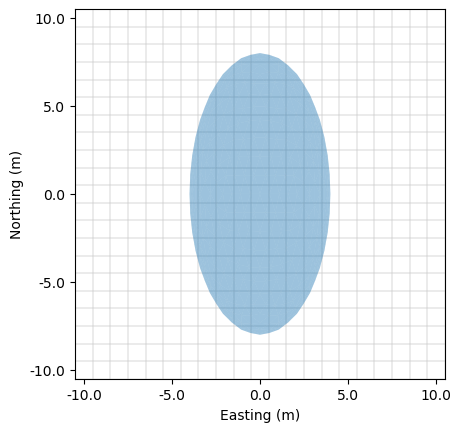

In [9]:
ranges = [8, 4, 0]
ellipse = rmsp.Solid.ellipsoid(ranges=ranges)
fig, ax, cax = grid2d.sectionplot(**grid_plot_params, title="")
ellipse.sectionplot_draw(ax=ax, coordinate=0)

Define a list of multiple azimuths:

In [10]:
azimuths = [30.0, 110.0, 265.0, 339.0]

Iterate over the rotations and plot the ellipses:

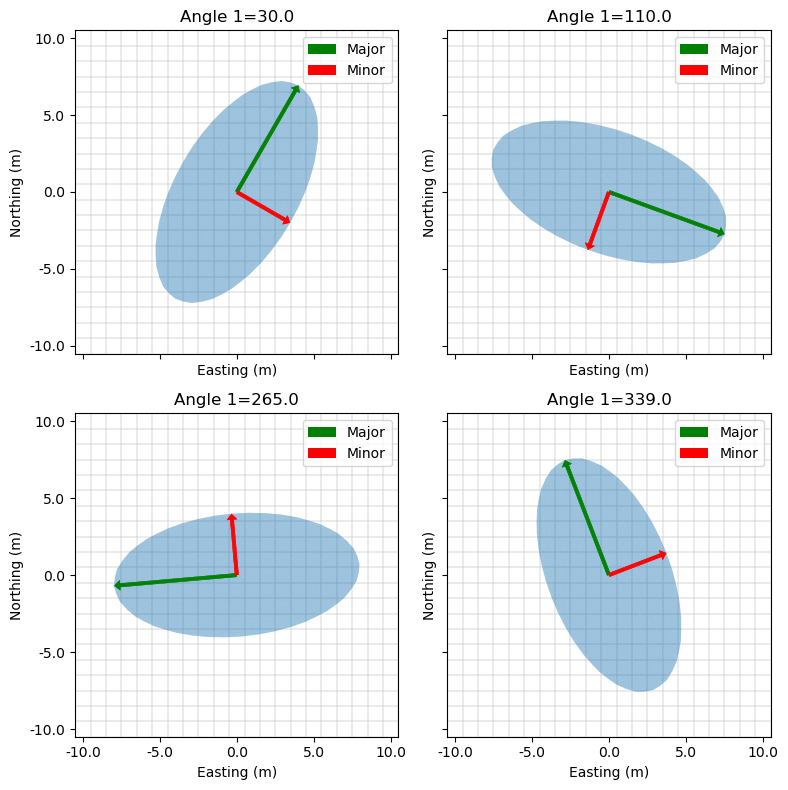

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex="all", sharey="all")
for ax, azm in zip(axes.flat, azimuths):

    # Calculate rotation matrix before applying it to ellipse and principal vectors
    rotation_matrix = about_z(radians(azm))
    rot_ellipse = rotate_ellipsoid(ellipse, rotation_matrix)
    principals = get_principal_axes(
        ranges, rotation_matrix, (0, 0, 0), arrow_pars["2d"], vert=False)

    # Plot the ellipse and arrows over the grid
    grid2d.sectionplot(ax=ax, title=f"Angle 1={azm}", **grid_plot_params)
    rot_ellipse.sectionplot_draw(ax=ax, coordinate=0, tolerances=0.1)
    ax = annotate_2d_ellipse(ax, principals, arrow_kws["2d"])
    _ = ax.legend()
fig.tight_layout()

---
# 3D Example

In this example we will extract a rotated, anisotropic ellipsoid from a variogram model fit to copper composite data. We will then initialize an unrotated source ellipsoid and demonstrate the three elemental rotations used to achieve the final orientation. The intermediate ellipsoids and principal angles are shown in 3D relative to the drillhole data and final target ellipsoid. Finally, rotation of the source ellipsoid is demonstrated using the full rotation matrix in a single step. _Note the figures in this section are intended to be interactive and viewed in 3D_.

## Load Data

Prior to demonstrating rotations, the target search ellipsoid will be visualized with respect to the data, emphasizing that the anisotropy that these rotations facilitate is typically based on continuity of regionalized random variables (copper grade here).

Load example data:

In [12]:
comps = rmsp.load_example_data("copper_composite", set_params=True)
comps.head()

,DHID,FROM,TO,x,y,z,startx,starty,startz,endx,endy,endz,CU,ELEM_A,ELEM_B,ELEM_C,ELEM_D,DENSITY,GEOCODE
0,DDH-0001,0.0,5.0,820.941053,12244.73598,1208.492476,820.945000,12243.87900,1210.841000,820.935784,12245.59520,1206.144771,NaN,NaN,NaN,NaN,NaN,NaN,D
1,DDH-0001,5.0,10.0,820.929193,12246.45665,1203.797888,820.935784,12245.59520,1206.144771,820.921280,12247.32033,1201.451831,NaN,NaN,NaN,NaN,NaN,NaN,D
2,DDH-0001,10.0,15.0,820.912045,12248.18625,1199.106601,820.921280,12247.32033,1201.451831,820.901488,12249.05440,1196.762202,NaN,NaN,NaN,NaN,NaN,NaN,D
3,DDH-0001,15.0,20.0,820.889610,12249.92477,1194.418636,820.901488,12249.05440,1196.762202,820.876410,12250.79738,1192.075906,NaN,NaN,NaN,NaN,NaN,NaN,D
4,DDH-0001,20.0,25.0,820.861888,12251.67222,1189.734015,820.876410,12250.79738,1192.075906,820.846044,12252.54928,1187.392965,NaN,NaN,NaN,NaN,NaN,NaN,D


Center the data on a [0, 0, 0] origin, which isn't required but simplifies rotations and visualizations:

In [13]:
for i, d in enumerate(['x', 'y', 'z']):
    for prefix in ['start', 'end', '']:
        comps[prefix + d] -= comps.spatial_centroid[i]
origin = np.round(comps.spatial_centroid, 3)
origin

array([ 0.,  0., -0.])

Initialize the anisotropic variogram model with rotation using a GSLIB-style variogram string (fit separately to the data):

In [14]:
variomod = rmsp.VarioModel(
    vario_str="""1    0.180             - num_struct, nugget
    1    0.820   32.3   77.0   33.4     - shape, var_contrib, angle1, angle2, angle3
                414.0   276.0  90.3     - range1, range2, range3"""
)
variomod

             Nugget Structure 1
Contribution  0.180       0.820
Model Shape           spherical
Angle 1                    32.3
Angle 2                    77.0
Angle 3                    33.4
Range 1                   414.0
Range 2                   276.0
Range 3                    90.3

Generate a search ellipsoid based on an isocontour of the variogram at $\gamma=0.5$:

In [15]:
target_search = rmsp.Search.from_vario_buffer(variomod, buffer_at=0.5)
target_ellipsoid = target_search.to_solid()
target_search

Search Parameters:
Angle 1      32.3
Angle 2      77.0
Angle 3      33.4
Range 1     143.8
Range 2      95.9
Range 3      31.4
Max. Comps  10000

Visualize the anisotropic search ellipsoid in the context of the data:

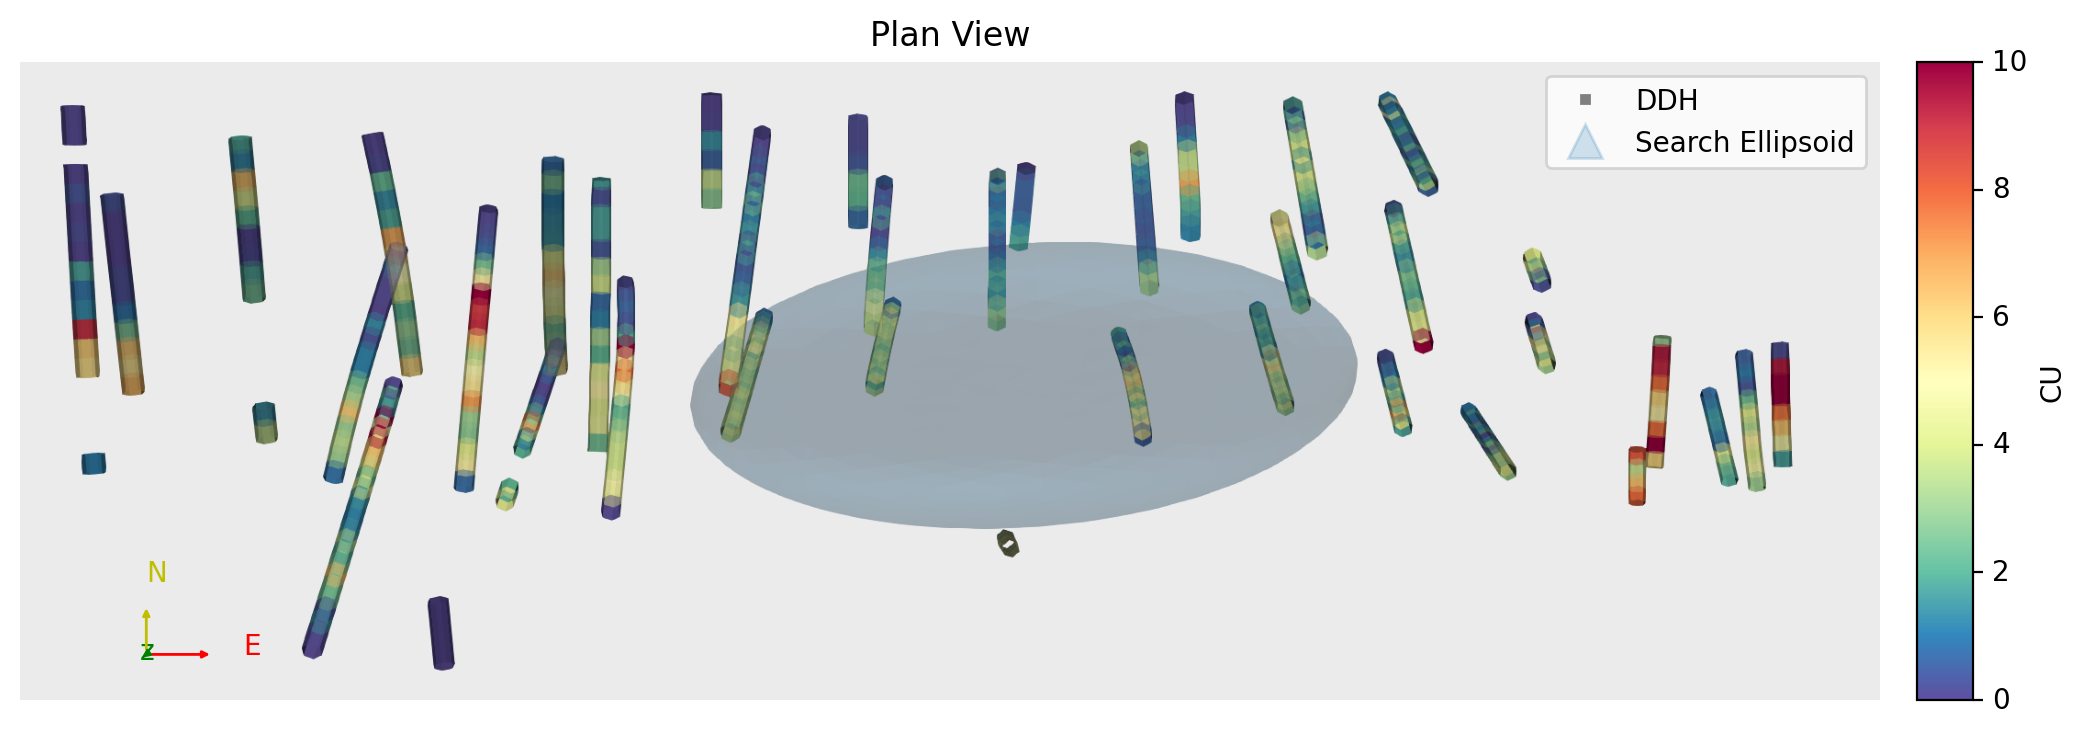

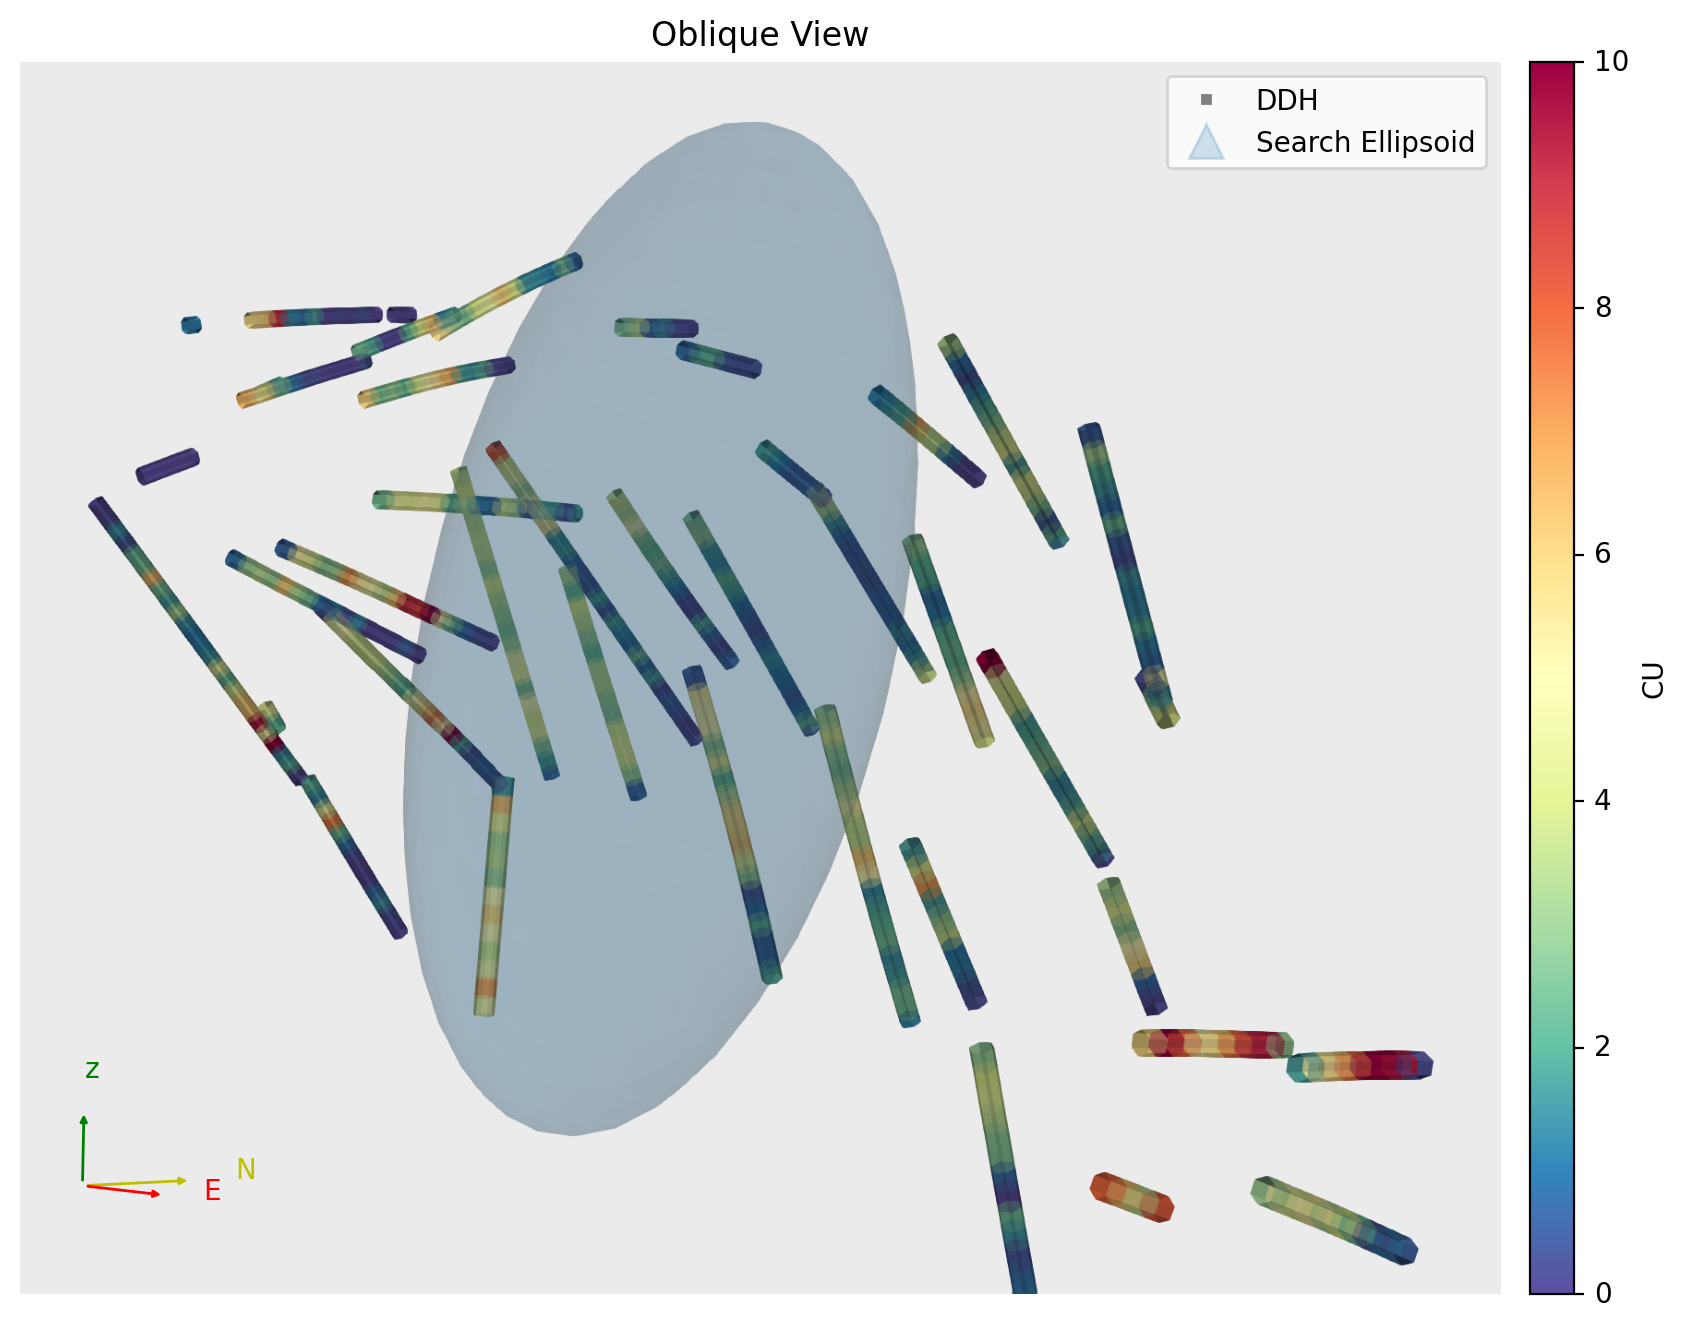

In [16]:
viewer = comps.view3d("CU", representation='Surface', label="DDH")
target_ellipsoid.view3d(color="C0", alpha=0.2, label="Search Ellipsoid",
                        viewer=viewer)
for name, angle in camera_params.items():
    viewer.set_camera(angle)
    fig, ax = viewer.show_static(title=name.capitalize() + " View")
    ax.legend()

# viewer  # uncomment for interactive view

## Elemental Rotations

Extract the target ranges and rotation angles (converted to radians):

In [17]:
ranges = target_search.ranges
ang1, ang2, ang3 = [radians(x) for x in target_search.angles]

Initialize an unrotated ellipsoid with the same anisotropy ratios:

In [18]:
target_ellipsoid = target_search.to_solid(origin)
ellipsoid = rmsp.Solid.ellipsoid(ranges=ranges, origin=origin)
principals0 = get_principal_axes(ranges, np.eye(3, 3),
                                 origin, arrow_pars["3d"])

Plot the unrotated ellipsoid and principal arrows with the target ellipsoid:

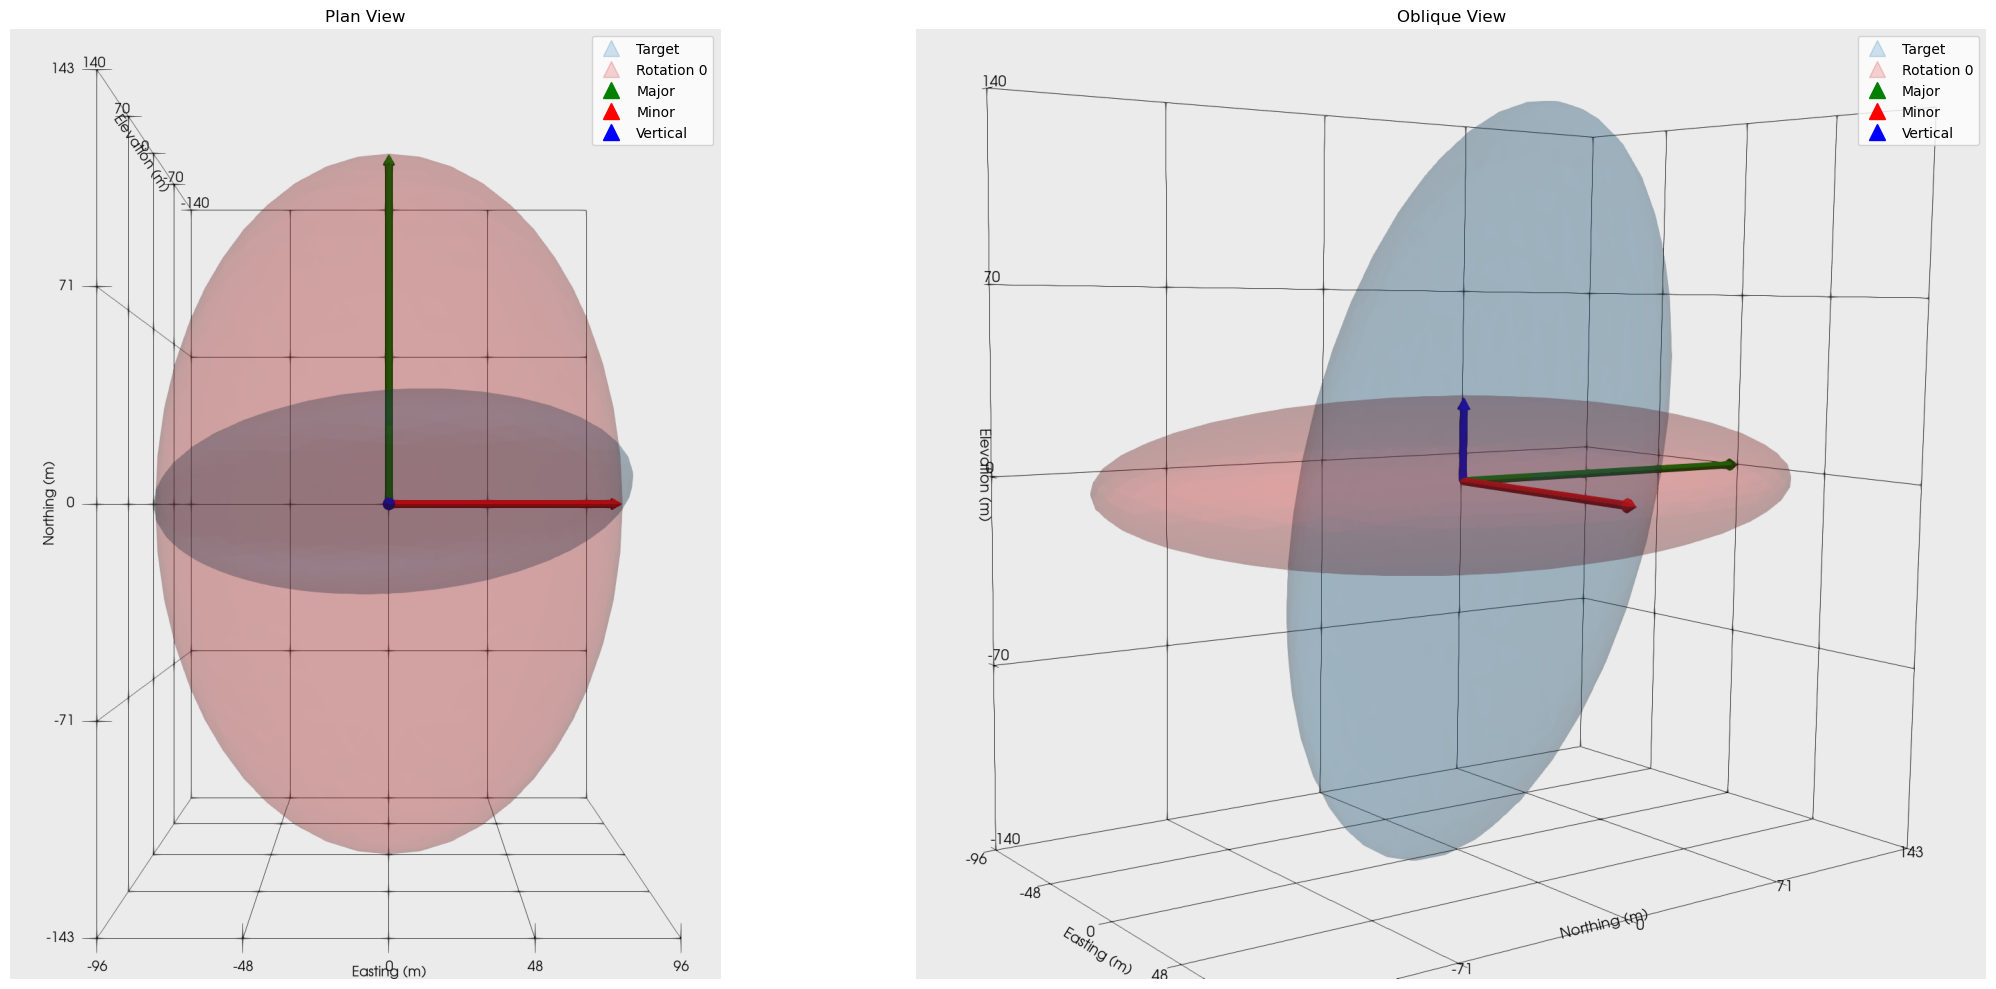

In [19]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid, principals0, "Rotation 0")
# viewer  # uncomment for interactive view

Perform the first elemental rotation about the Z axis:

In [20]:
rotmat1 = about_z(ang1)
ellipsoid_rot1 = rotate_ellipsoid(ellipsoid, rotmat1)
principals1 = get_principal_axes(ranges, rotmat1, origin, arrow_pars["3d"])

Plot the ellipsoid after the first rotation:

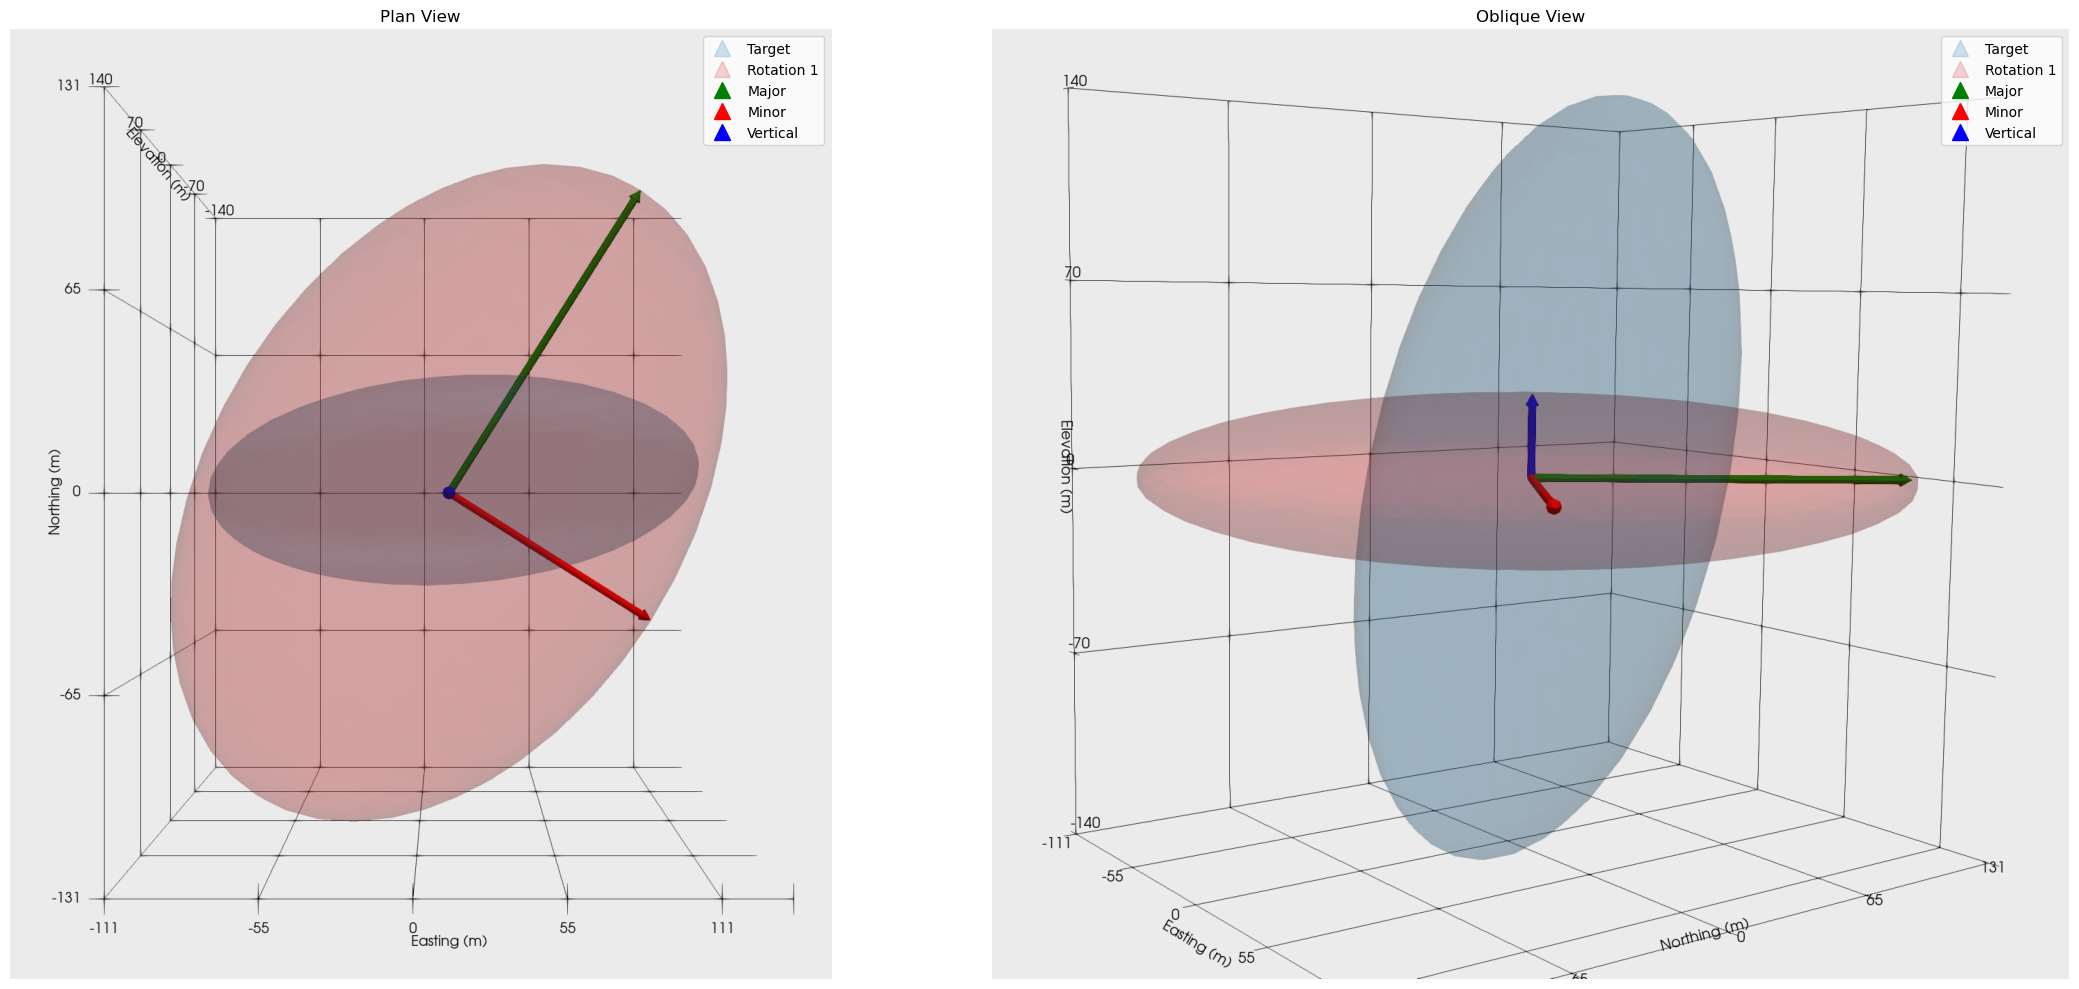

In [21]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid_rot1, principals1, "Rotation 1")
# viewer  # uncomment for interactive view

Perform the second elemental rotation about the new X axis:

In [22]:
rotmat2 = np.matmul(about_x(ang2), rotmat1)
ellipsoid_rot12 = rotate_ellipsoid(ellipsoid, rotmat2)
principals2 = get_principal_axes(
    ranges,
    rotmat2,
    origin,
    arrow_pars["3d"],
)

Plot the ellipsoid after the second rotation:

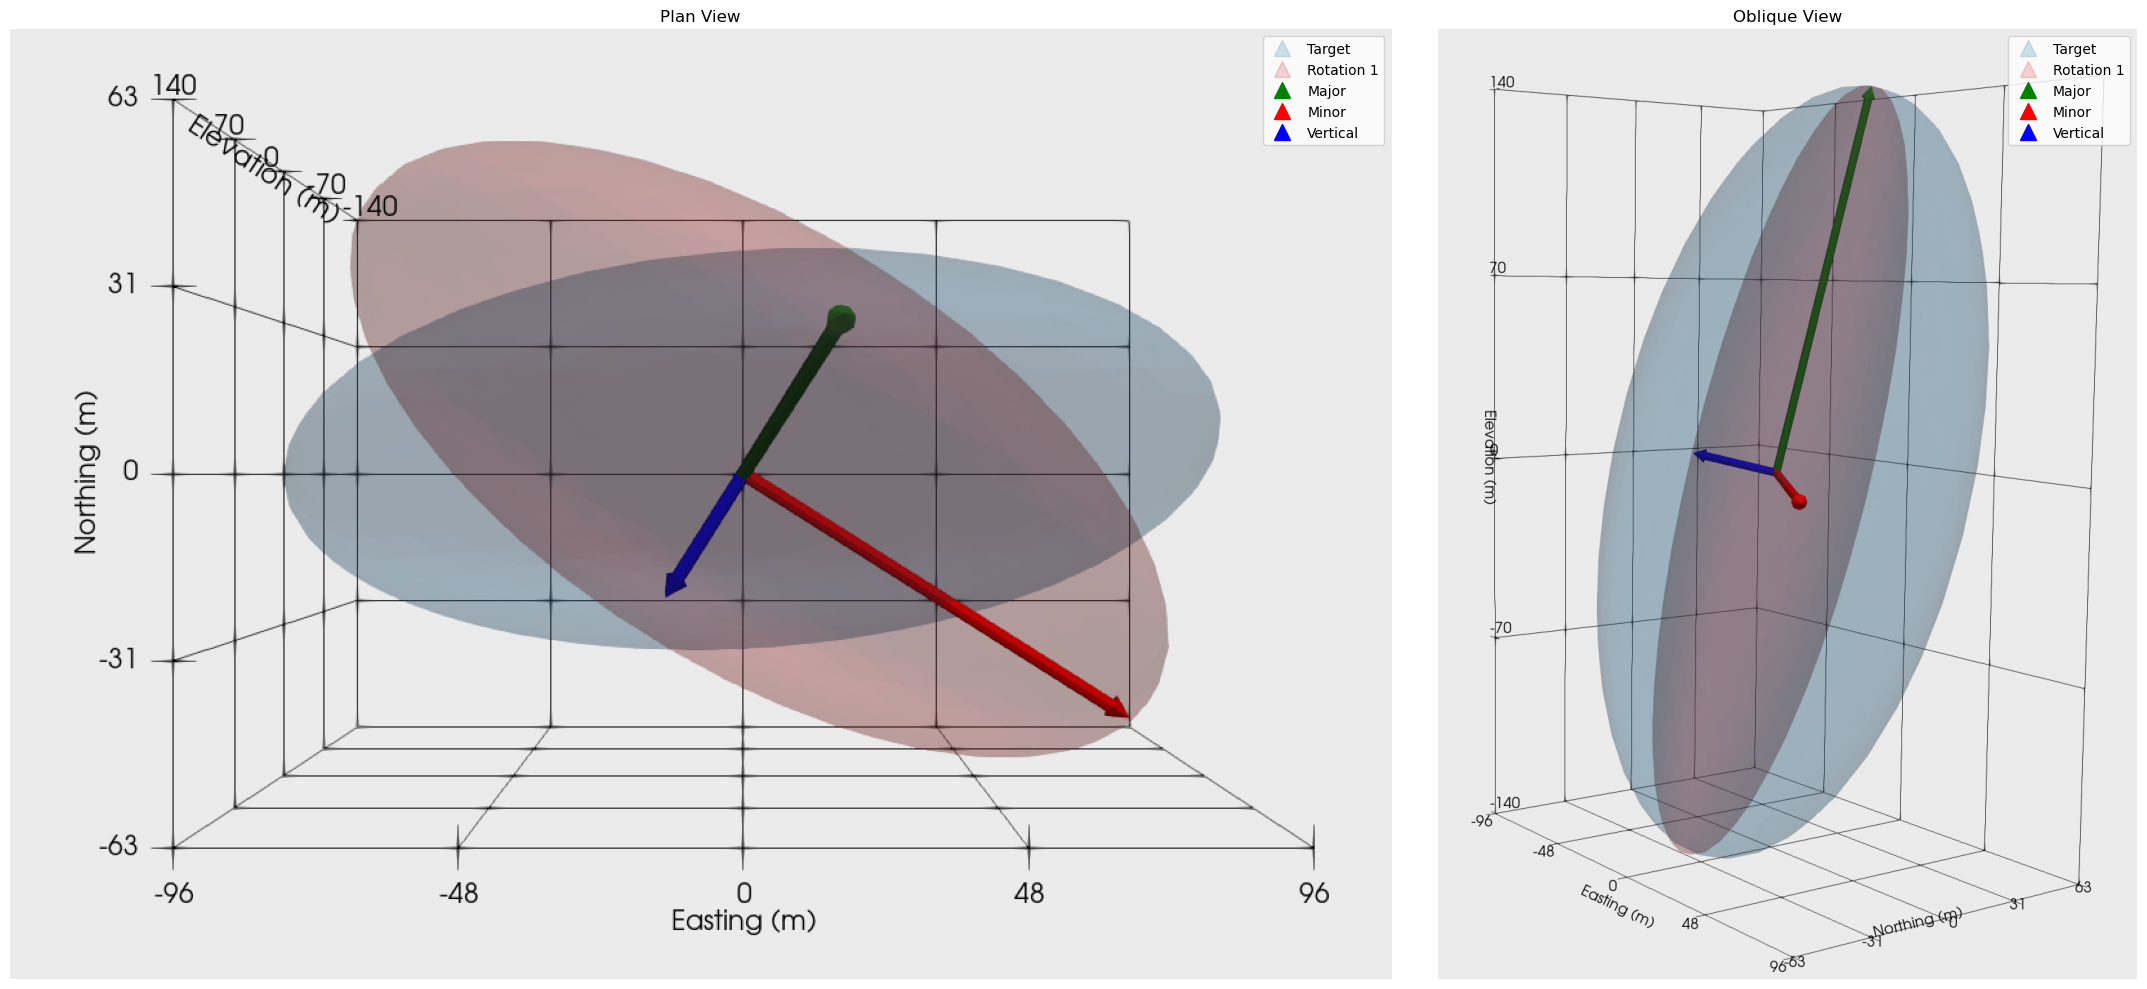

In [23]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid_rot12, principals2, "Rotation 1")
# viewer  # uncomment for interactive view

Perform the third elemental rotation about the new Y axis:

In [24]:
rotmat3 = np.matmul(about_y(ang3), rotmat2)
ellipsoid_rot123 = rotate_ellipsoid(ellipsoid, rotmat3)
principals3 = get_principal_axes(
    ranges,
    rotmat3,
    origin,
    arrow_pars["3d"],
)

Plot the ellipsoid after the third rotation:

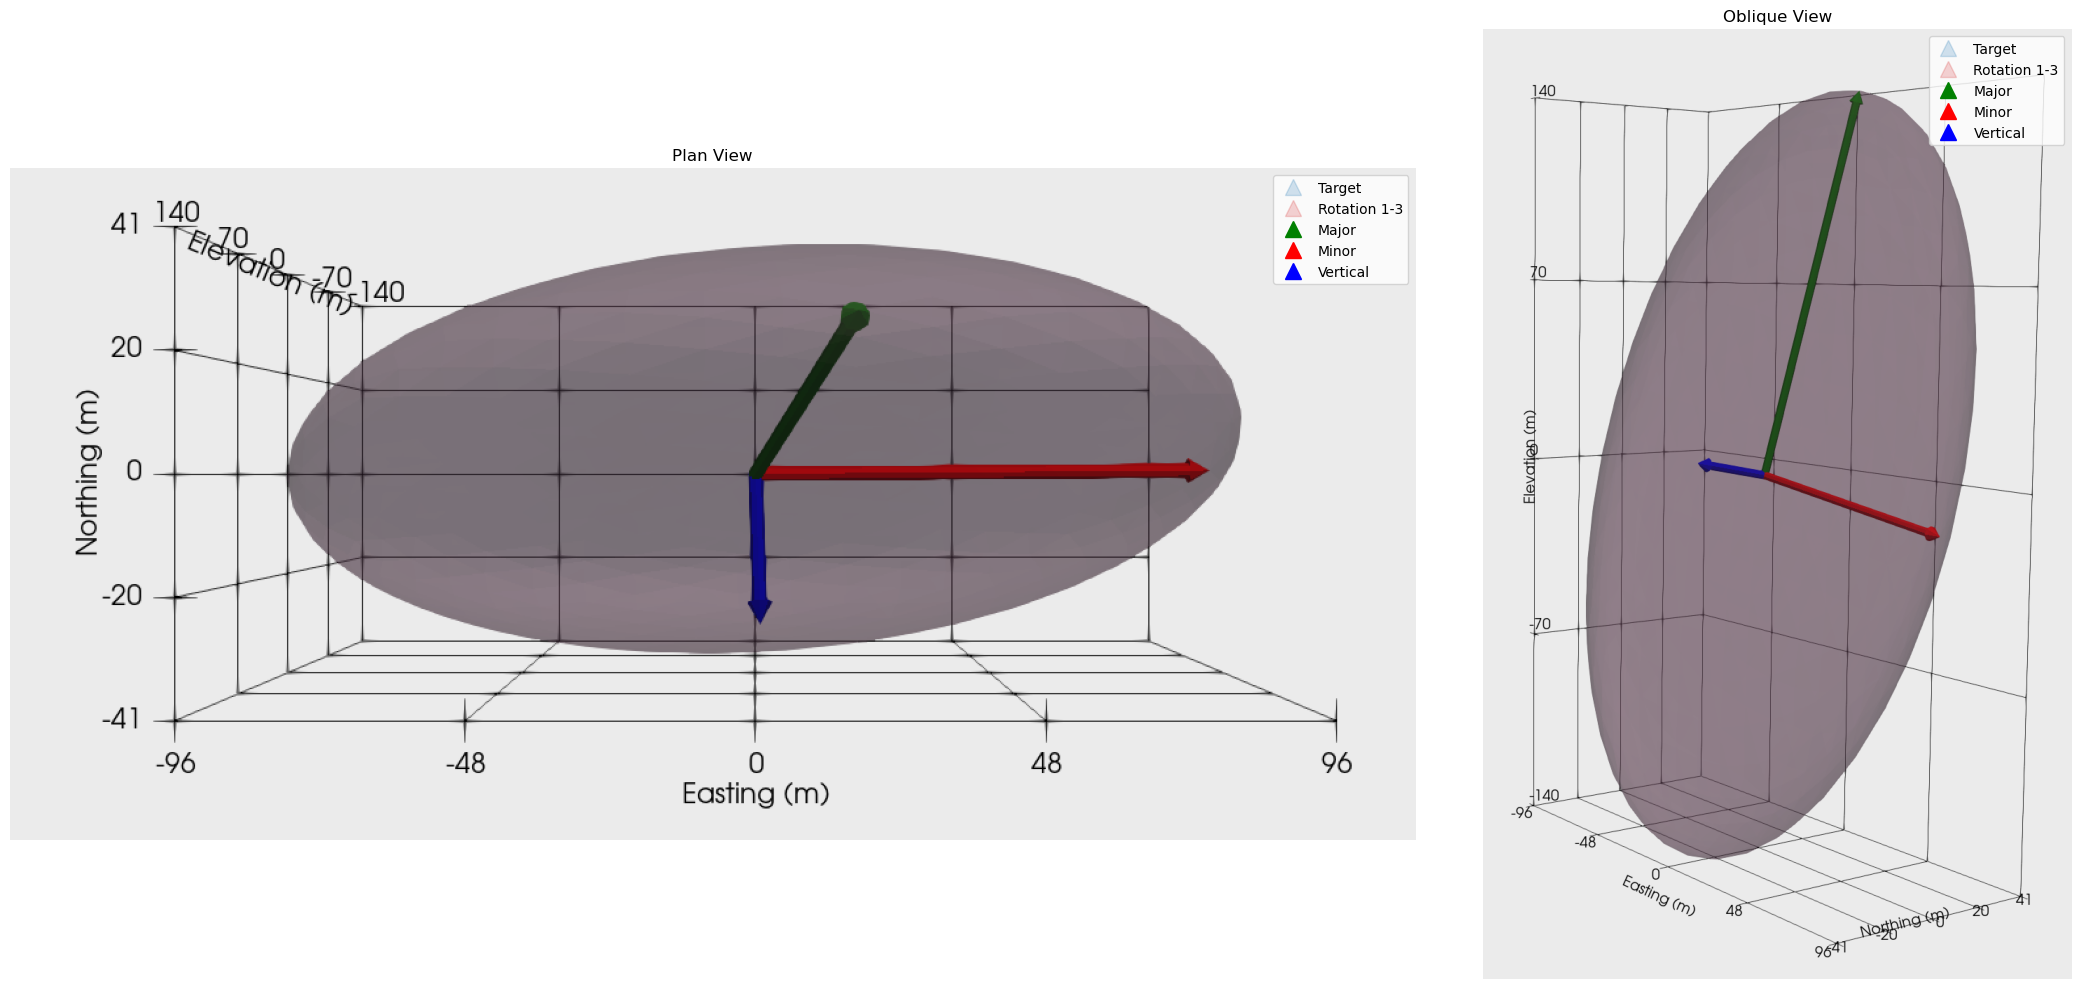

In [25]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid_rot123, principals3, "Rotation 1-3")
# viewer  # uncomment for interactive view

## Full Rotation Matrix

Note, all rotations can be achieved simultaneously by applying the final rotation matrix:

In [26]:
rotmat_gslib = gslib_rotation_matrix(ang1, ang2, ang3)
ellipsoid_rot_gslib = rotate_ellipsoid(ellipsoid, rotmat_gslib)
principals_gslib = get_principal_axes(
    ranges, rotmat_gslib, origin, arrow_pars["3d"], vert=True
)

Plot the ellipsoids, noting the target and rotated ellipsoids overlap perfectly:

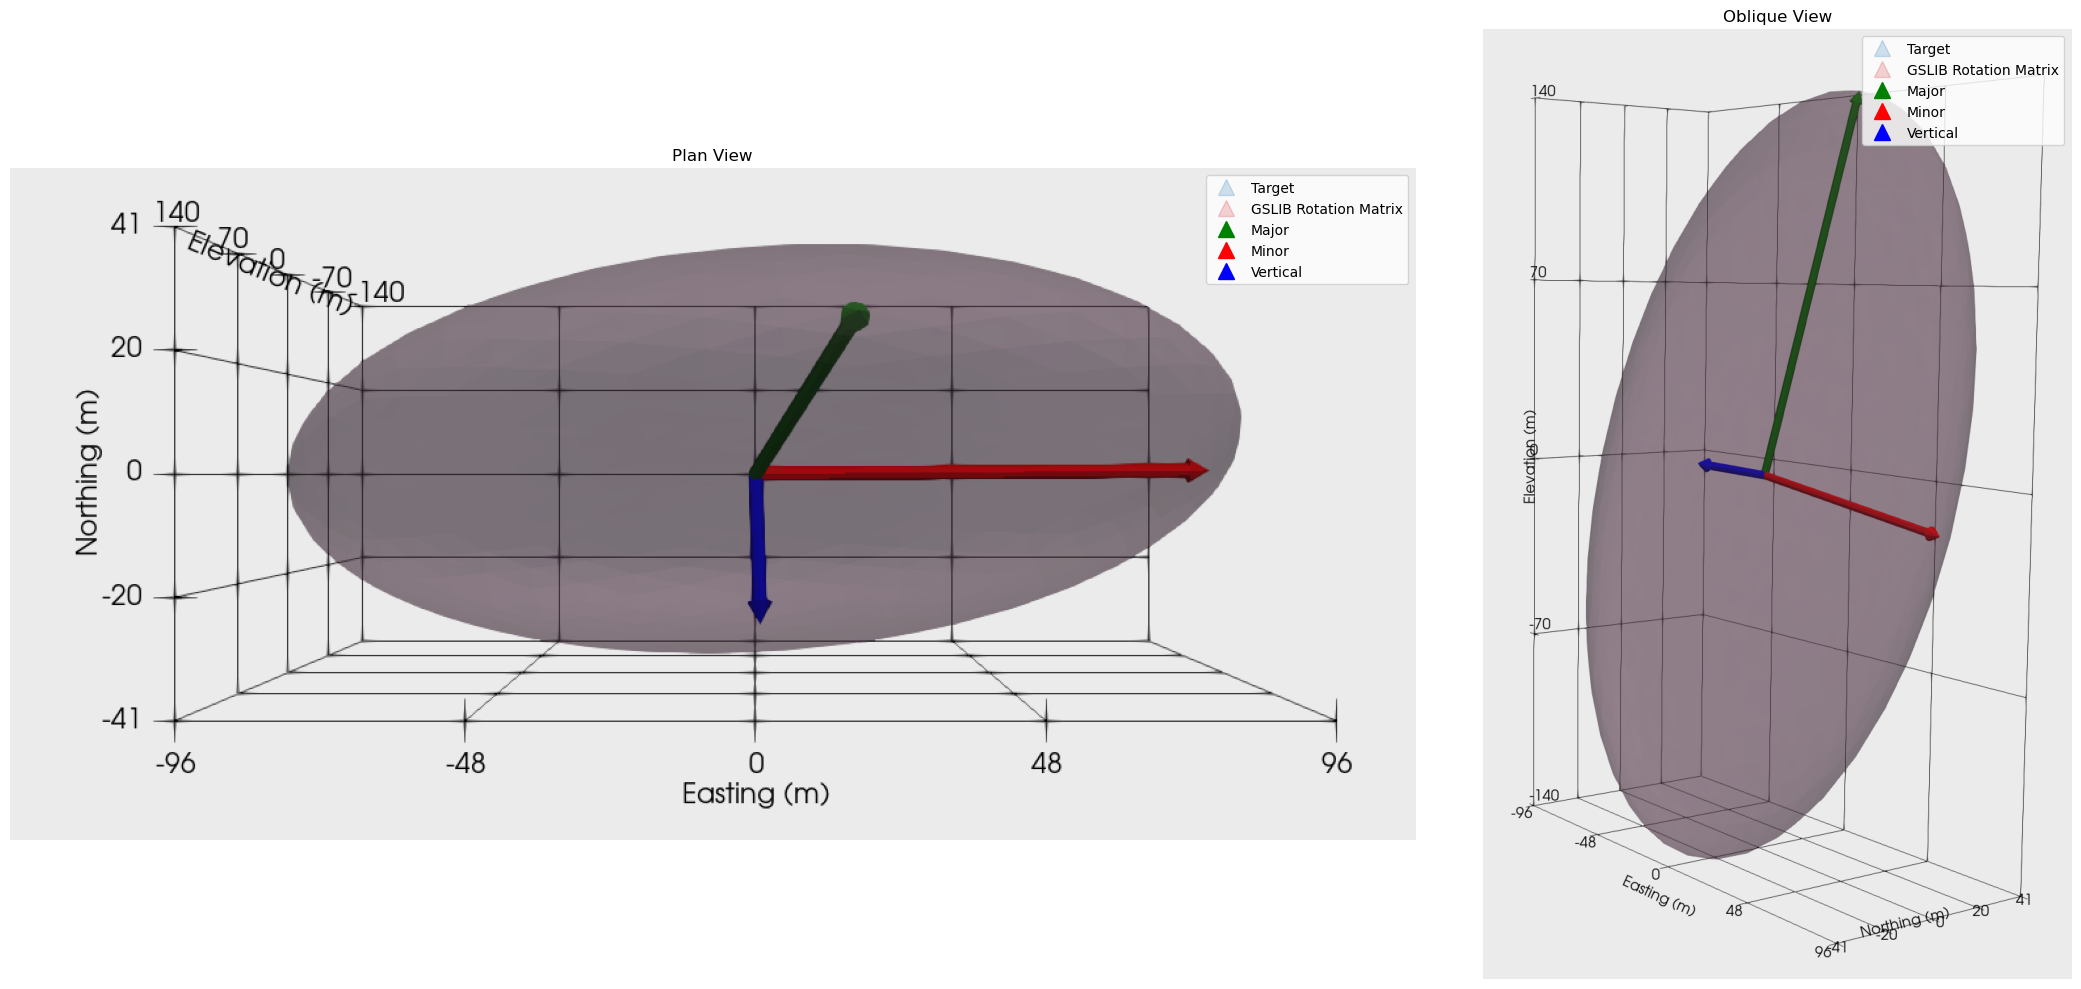

In [27]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid_rot_gslib, principals_gslib, "GSLIB Rotation Matrix")
# viewer  # uncomment for interactive view

As the rotation matrix is orthogonal by construction, and therefore $R^{-1}=R^{T}$, the rotations can be reversed by multiplying by the matrix transpose: 

In [28]:
ellipsoid_orig = rotate_ellipsoid(ellipsoid_rot_gslib, rotmat_gslib.T)
principals_orig = get_principal_axes(
    ranges, np.eye(3), origin, arrow_pars["3d"], vert=True
)

Plot the unrotated ellipsoid:

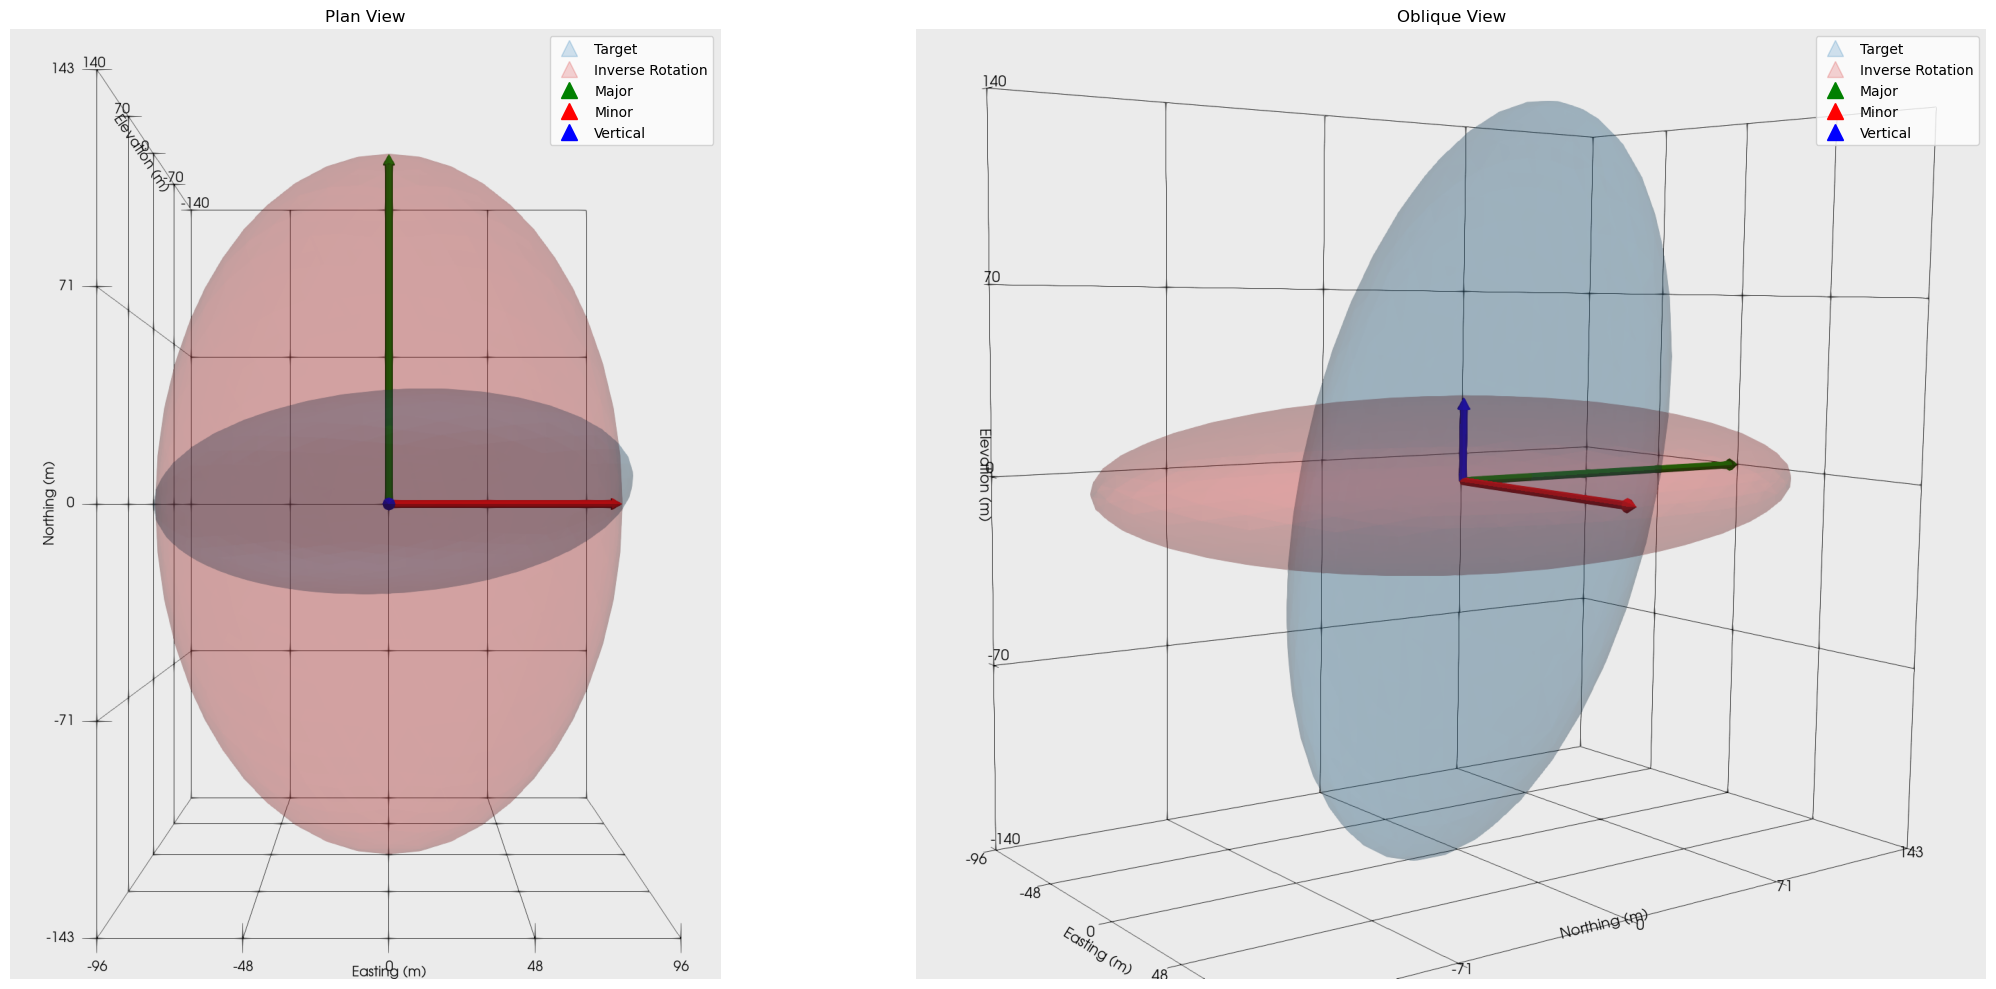

In [29]:
viewer = view_ellipsoids(target_ellipsoid, ellipsoid_orig, principals_orig, "Inverse Rotation")
# viewer  # uncomment for interactive view

---
# Rotation Conventions in RMSP

RMSP uses the GSLIB rotation convention for representing search ellipsoids and other orientations in 3D. This convention considers three rotations about the vertical, minor, and finally major axes. However, other software packages use different rotation axes, different initial orientations, and different sign conventions.

The `rmsp.RotationConvention` class encodes several of the conventions for different software packages and others can be specified programmatically. This class also provides a method for converting from one convention to another.

Convert a set of angles from Datamine™ to GSLIB:

In [30]:
gslib = rmsp.RotationConvention.gslib()
datamine = rmsp.RotationConvention.datamine(axis_order="zxz", major="x")

datamine_angles = (120, 45, 30)
gslib_angles = datamine.to(gslib, *datamine_angles)
print(gslib_angles)

(-127.79234570140352, 20.704811054635442, -40.89339464913091)


---
# Concluding Remarks

The rotation of an object in three-dimensional space can be defined by three elemental rotations. In software following the GSLIB rotation convention, these occur sequentially: first around the Z-axis (azimuth), then around the new X-axis (inclination), and finally around the new Y-axis (tilt). This notebook explores the mathematics behind these rotations, which play a crucial role in various geological modeling workflows. Understanding these principles is also essential for converting between different rotation conventions—a process that can be complex and a common source of confusion among practitioners. To simplify this, RMSP provides the `RotationConvention` class, which facilitates conversion between conventions.

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>